<a href="https://colab.research.google.com/github/ShainiRose/To-Do-List-Web-Application/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [22]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [23]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = (4, np.random.randint(0, 5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        """Moves the agent in the specified direction."""
        last_location = self.current_location

        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

    def reset(self):
        """Reset the environment and return the initial state"""
        self.__init__()  # reinitialize the environment
        return self.current_location

    def step(self, action):
        """Take a step in the environment and return next_state, reward, done"""
        reward = self.make_step(action)
        done = self.check_state() == 'TERMINAL'
        next_state = self.current_location
        return next_state, reward, done


In [24]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [26]:
""" class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment #type the code
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):

        import random

        # Exploration vs Exploitation
        if random.uniform(0, 1) < self.epsilon:
            # Explore: random action
            action = random.choice(available_actions)
        else:
            # Exploit: choose best action(s) from Q-table
            state = self.environment.current_location
            q_values = self.q_table[state]
            max_q = max(q_values[a] for a in available_actions)

            # If multiple actions have the same Q-value, pick randomly among them
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            action = random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        #Updates the Q-value table using Q-learning
        # Current Q-value
        old_q = self.q_table[old_state][action]

        # Best future Q-value
        future_q = max(self.q_table[new_state].values())

        # Q-learning update rule
        new_q = old_q + self.alpha * (reward + self.gamma * future_q - old_q)

        # Update Q-table
        self.q_table[old_state][action] = new_q
        """


class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1, gamma=0.99, lr=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma

        self.memory = deque(maxlen=10000)
        self.batch_size = 64

        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
            return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()




In [27]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

 ''' ## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [28]:
"""
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

"""

'\nenv = GridWorld()\nagent = RandomAgent()\n\nprint("Current position of the agent =", env.current_location)\nprint(env.agent_on_map())\navailable_actions = env.get_available_actions()\nprint("Available_actions =", available_actions)\nchosen_action = agent.choose_action(available_actions)\nprint("Randomly chosen action =", chosen_action)\nreward = env.make_step(chosen_action)\nprint("Reward obtained =", reward)\nprint("Current position of the agent =", env.current_location)\nprint(env.agent_on_map())\n\n'

- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

In [29]:
"""

# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)  """

'\n\n# Initialize environment and agent\nenvironment = GridWorld()\nrandom_agent = RandomAgent()\n\nreward_per_episode = play(environment, random_agent, trials=500)\n\n# Simple learning curve\nplt.plot(reward_per_episode)  '

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

In [30]:
"""
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)
"""

'\nenvironment = GridWorld()\nagentQ = Q_Agent(environment)\n\n# Note the learn=True argument!\nreward_per_episode = play(environment, agentQ, trials=500, learn=True)\n\n# Simple learning curve\nplt.plot(reward_per_episode)\n'

/tmp/ipython-input-3888523577.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states)


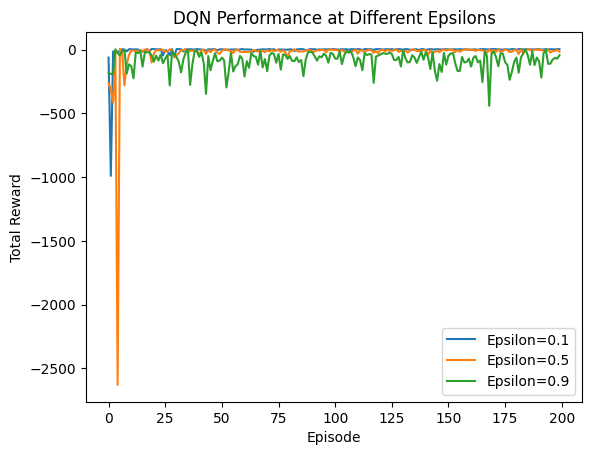

In [31]:
# ---------------- Run DQN Agent ----------------
env = GridWorld()
state_dim = 2   # (x,y) position
action_dim = len(env.actions)

# Try multiple epsilon values
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    agent = DQNAgent(state_dim, action_dim, epsilon=eps)
    episodes = 200
    rewards = []

    for ep in range(episodes):
        state = np.array(env.reset(), dtype=np.float32)
        total_reward = 0
        done = False

        while not done:
            action_idx = agent.select_action(state)
            action = env.actions[action_idx]

            next_state, reward, done = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)

            agent.store_transition(state, action_idx, reward, next_state, done)
            agent.train()

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    results[eps] = rewards

# Plot comparison
import matplotlib.pyplot as plt
for eps, rewards in results.items():
    plt.plot(rewards, label=f"Epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("DQN Performance at Different Epsilons")
plt.show()


""Print the final Q-value table with nice formatting.

In [ ]:
"""
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

"""

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.219
	LEFT
		-0.2
	RIGHT
		-0.296749
(0, 1)
	UP
		-0.2
	DOWN
		-0.1
	LEFT
		-0.1
	RIGHT
		5.842854245723666
(0, 2)
	UP
		-0.1
	DOWN
		3.2112186919826025
	LEFT
		1.74411840022029
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		3.5279776117966533
	DOWN
		0.3645402556198174
	LEFT
		9.999950781191618
	RIGHT
		0
(0, 5)
	UP
		-0.1
	DOWN
		-0.20900000000000002
	LEFT
		-1.3877787807814457e-17
	RIGHT
		-0.11000000000000001
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.30988857000000003
	LEFT
		-0.271
	RIGHT
		-0.30000000000000004
(0, 7)
	UP
		-0.29000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		-0.381
	RIGHT
		-0.30000000000000004
(1, 0)
	UP
		-0.45552000000000004
	DOWN
		-0.45448681848600003
	LEFT
		-0.5
	RIGHT
		-0.4508683032467194
(1, 1)
	UP
		-0.28900000000000003
	DOWN
		-0.337291
	LEFT
		-0.30000000000000004
	RIGHT
		4.709340326070914
(1, 2)
	UP
		8.999999999999986
	DOWN
		3.7999552679912036
	LEFT
		0.996

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving q5.png to q5.png


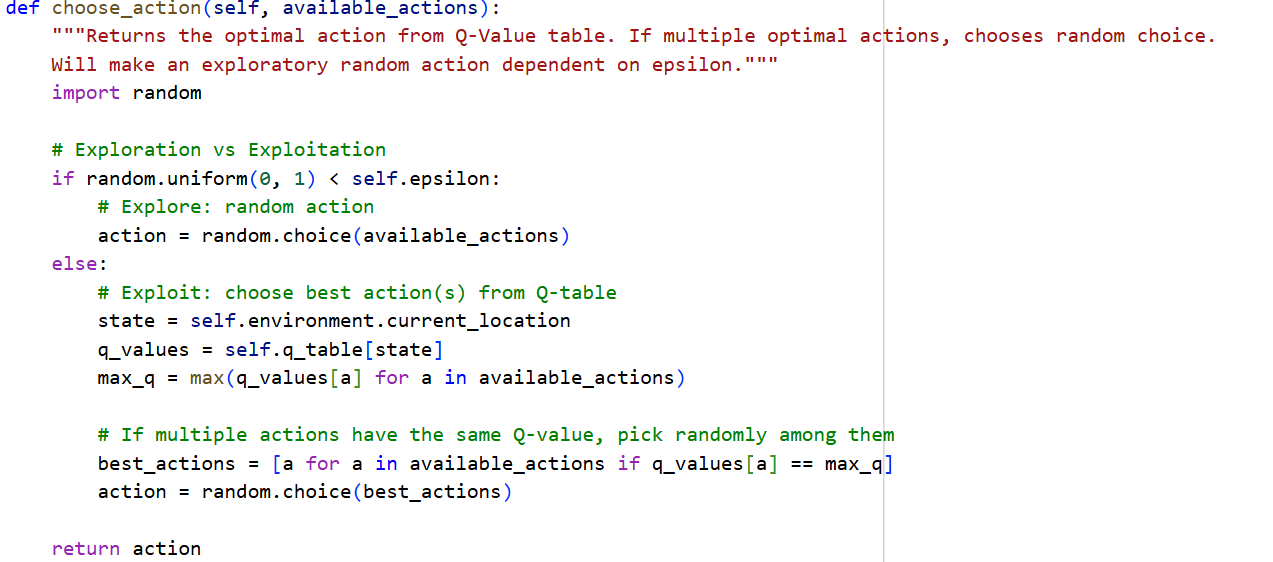

In [ ]:
from IPython.display import Image
Image('q5.png')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving q6.png to q6.png


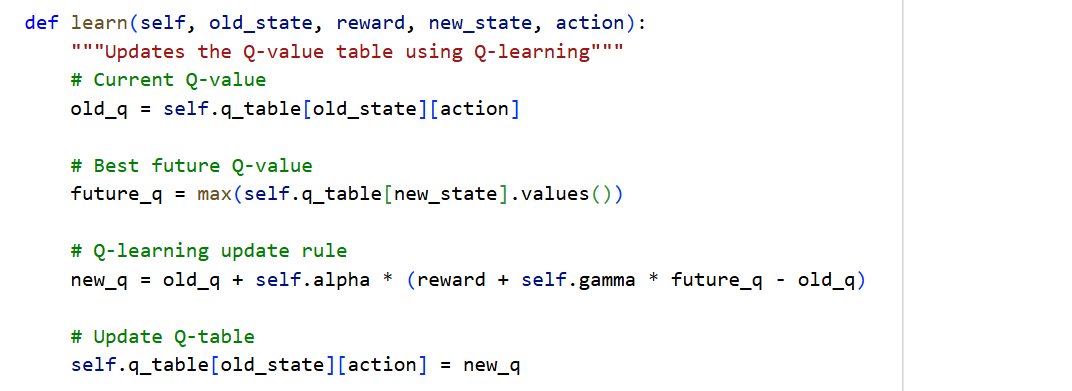

In [ ]:
from IPython.display import Image
Image('q6.png')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving q8.png to q8.png


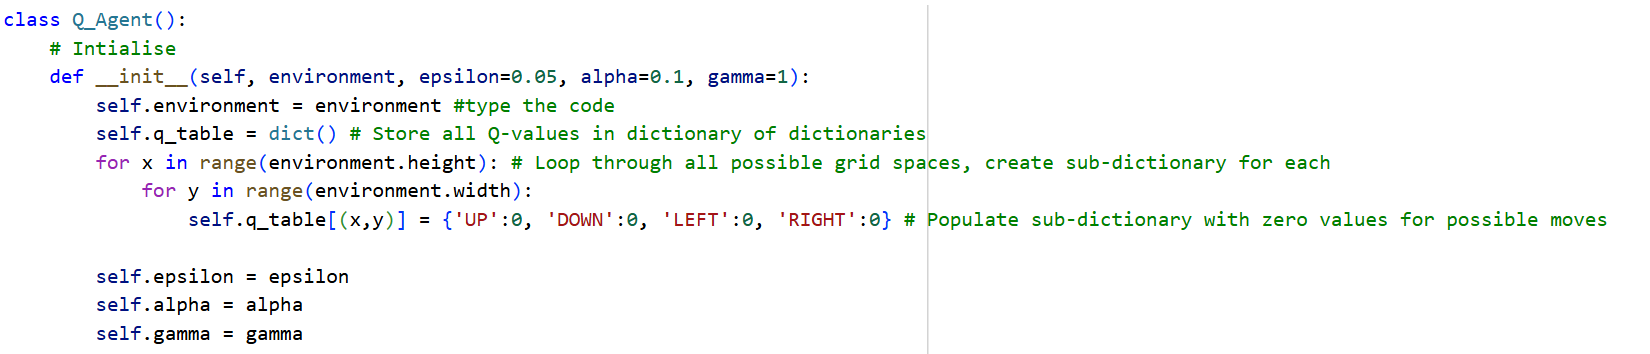

In [ ]:
from IPython.display import Image
Image('q8.png')